<a href="https://colab.research.google.com/github/hayleypc/HawaiiClimate/blob/main/gen_soil_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [4]:
def preprocess_data(matched_data):
    # Initial preprocessing
    matched_data['distance'] = 0
    matched_data = matched_data[matched_data["depth_adj_bottom"] == '20']
    matched_data['imp_c_float'] = [float(datum) for datum in matched_data['imp_c']]

    # Select ID fields that are non-numeric since can't run minmax scalar over non numeric
    id_fields = matched_data[['source_dataset', 'island','dist_id', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]

    # Select numeric columns and preprocess
    keep_cols = ['water', 'trees','grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built',
                 'bare', 'snow_and_ice', 'max', 'elevation', 'landform', 'SRTM_mTPI','aet', 'def',
                 'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn','tmmx', 'vap', 'vpd', 'vs',
                 'agbd_m', 'agbd_sd', 'agbd_n']
    numeric_cols = matched_data[keep_cols]
    numeric_cols.replace('', np.nan, inplace=True)
    numeric_cols = numeric_cols.astype(float)
    numeric_cols.fillna(0, inplace=True)

    # Scale numeric columns
    scaler = MinMaxScaler()
    scaler.fit(numeric_cols)
    scaled_numeric_cols = scaler.transform(numeric_cols)
    scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)

    #min max scale imp_c, keep scalers
    min_c = np.min(matched_data['imp_c_float'])
    max_c = np.max(matched_data['imp_c_float'])
    scaled_imp_c = (matched_data['imp_c_float'] - min_c) / (max_c - min_c)

    # Combine ID fields with scaled numeric data
    numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)

    numeric_df['imp_c_scaled'] = scaled_imp_c

    return numeric_df, scaler, min_c, max_c

In [5]:
def train_model_a(preprocess_data):

    keep_cols = ['water', 'trees','grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built',
                'bare', 'snow_and_ice', 'max', 'elevation', 'landform', 'SRTM_mTPI','aet', 'def',
                'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn','tmmx', 'vap', 'vpd', 'vs',
                'agbd_m', 'agbd_sd', 'agbd_n']

    X = preprocess_data[keep_cols]

    y = preprocess_data['imp_c_scaled']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define model
    def build_model(input_shape):
        model = Sequential([
            Dense(256, activation='relu', input_dim=input_shape),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(512, activation='relu'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(1024, activation='relu'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(1, activation='linear')
        ])
        return model

    model = build_model(X_train.shape[1])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)

    test_loss = model.evaluate(X_test, y_test)
    predictions = model.predict(X_test).flatten()
    r_squared = r2_score(y_test, predictions)

    return model, test_loss, r_squared, predictions, y_test

In [6]:
# imputed SOC dostributions
file_path = '/content/drive/MyDrive/hawaii_soils/HI soils data/annotated_combo_imputed_SOC.gpkg'

gdf = gpd.read_file(file_path)

In [7]:
def predict_on_reserve(preprocess_data, model, min_c, max_c):

    df_out = preprocess_data.copy()
    keep_cols = ['water', 'trees','grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built',
                'bare', 'snow_and_ice', 'max', 'elevation', 'landform', 'SRTM_mTPI','aet', 'def',
                'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn','tmmx', 'vap', 'vpd', 'vs',
                'agbd_m', 'agbd_sd', 'agbd_n']

    X = preprocess_data[keep_cols]
    y = preprocess_data['imp_c_scaled']

    # Predictions and Evaluation
    predictions = model.predict(X)

    inversed_predictions =  predictions*max_c+min_c

    inversed_truth =  y*max_c+min_c

    df_out['predictions'] = predictions
    df_out['inversed_predictions'] = inversed_predictions
    df_out['inversed_imp_c'] = inversed_truth

    return df_out

In [37]:
def evaluate_model(model, X_test, y_test, scaler, inversed_predictions, inversed_truth):
    test_loss = model.evaluate(X_test, y_test)
    r_squared = r2_score(inversed_truth, inversed_predictions)

    print("Test Loss:", test_loss)
    print("R-Squared Score:", r_squared)

    mae = mean_absolute_error(inversed_truth, inversed_predictions)
    rmse = mean_squared_error(inversed_truth, inversed_predictions, squared=False)

    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", rmse)

    # Scatter plot of true vs predicted values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=inversed_truth, y=inversed_predictions)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("True vs Predicted Values")
    plt.plot([min(inversed_truth), max(inversed_truth)], [min(inversed_truth), max(inversed_truth)], 'r')  # Diagonal line
    plt.show()

    # Residual plot
    residuals = inversed_truth - inversed_predictions
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.xlabel("Residuals")
    plt.title("Distribution of Residuals")
    plt.show()

# model, test_loss, r_squared, inversed_predictions, inversed_truth, scaler, X_test, y_test = preprocess_and_train_model(matched_data)
# evaluate_model(model, X_test, y_test, scaler, inversed_predictions, inversed_truth)

NameError: name 'X_test' is not defined

In [9]:
file_path = '/content/drive/My Drive/sequence_data.csv'

In [10]:
drivers_gpd = gpd.read_file('/content/drive/MyDrive/hawaii_soils/Analysis Data/250_summary_grid_dt.gpkg')

In [11]:
soils_csv = gpd.read_file('/content/drive/MyDrive/hawaii_soils/HI soils data/combined_soc_2024_04_05.csv')

In [12]:
# Filter the DataFrame using .loc
soils_csv = soils_csv.loc[(soils_csv['latitude'] != '') & (soils_csv['longitude'] != '')]

# Create geometry column
soils_csv['geometry'] = soils_csv.apply(lambda row: Point(float(row['longitude']), float(row['latitude'])), axis=1)

# Convert to GeoDataFrame
soils_gpd = gpd.GeoDataFrame(soils_csv, geometry='geometry', crs="EPSG:4326")


In [13]:
soils_gpd = pd.merge(soils_gpd, gdf.loc[:,['dist_id','unique_id']], on='unique_id', how='inner')

In [15]:
# Ensure both GeoDataFrames have the same CRS
soils_gpd = soils_gpd.to_crs(drivers_gpd.crs)

# Perform spatial join
matched_data = gpd.sjoin_nearest(soils_gpd, drivers_gpd, how='left', distance_col='distance')

In [17]:
# Apply a buffer to each geometry in one of the GeoDataFrames (e.g., soils_gpd)
soils_buffered = soils_gpd.copy()

soils_buffered.geometry = soils_buffered.to_crs(epsg=32604).geometry.buffer(1000).to_crs('ESRI:102261')

# soils_gpd = soils_gpd
# Step 2: Spatial Join
# Perform a spatial join with the buffered GeoDataFrame
# This finds all drivers_gpd points that fall within the 10,000-meter buffer of any point in soils_gpd
matches_within_distance = gpd.sjoin(soils_buffered, drivers_gpd, how='left', predicate='intersects')


In [18]:
matches_within_distance

,source_dataset,island,soil_column_id,unique_id,depth_top,depth_bottom,depth_adj_bottom,latitude,longitude,c_perc,...,tmmx,vap,vpd,vs,agbd_m,agbd_sd,agbd_n,majorcomposition,age_years,age_class
0,FIA,Kauai,FIA_1060,FIA1,0,20,20,22.185643,-159.350787,4.19,...,270.557709,2041.600098,87.166664,390.250000,NaN,NaN,0.0,Hawaiite,64000.0,Holocene
0,FIA,Kauai,FIA_1060,FIA1,0,20,20,22.185643,-159.350787,4.19,...,270.557678,2041.600098,87.166672,390.250000,6.610543,3.998312,3.0,Tholeiitic Basalt,2000000.0,Holocene
0,FIA,Kauai,FIA_1060,FIA1,0,20,20,22.185643,-159.350787,4.19,...,270.557678,2041.599976,87.166672,390.250000,NaN,NaN,0.0,Tholeiitic Basalt,2000000.0,Holocene
0,FIA,Kauai,FIA_1060,FIA1,0,20,20,22.185643,-159.350787,4.19,...,270.557709,2041.599976,87.166664,390.250000,NaN,NaN,0.0,Tholeiitic Basalt,3000.0,Pre-Holocene
0,FIA,Kauai,FIA_1060,FIA1,0,20,20,22.185643,-159.350787,4.19,...,270.557678,2041.599976,87.166672,390.250000,NaN,NaN,0.0,Hawaiite,64000.0,Holocene
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6841,SH,Oahu,SH949-01,SH949,0,15,20,21.69591278,-158.0021119,1.88,...,276.388580,2087.295654,92.892563,418.779663,25.739703,42.307313,3.0,Tholeiitic Basalt,164.0,Pre-Holocene
6841,SH,Oahu,SH949-01,SH949,0,15,20,21.69591278,-158.0021119,1.88,...,275.569214,2079.497314,91.841026,419.679504,53.008643,96.268384,13.0,Tholeiitic Basalt,3000.0,Pre-Holocene
6841,SH,Oahu,SH949-01,SH949,0,15,20,21.69591278,-158.0021119,1.88,...,277.527435,2098.135010,94.354149,417.528900,52.225917,52.377630,6.0,Tholeiitic Basalt,573.0,Pre-Holocene
6841,SH,Oahu,SH949-01,SH949,0,15,20,21.69591278,-158.0021119,1.88,...,276.369019,2087.109619,92.867439,418.801147,25.595615,29.355879,9.0,Alkalic Basalt,3000.0,Pre-Holocene


In [19]:
numeric_df, scaler, min_c, max_c = preprocess_data(matches_within_distance)

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<ipython-input-4-48d85629ab51>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


In [20]:
frequency_table = numeric_df['unique_id'].value_counts().reset_index()
frequency_table.columns = ['unique_id', 'count']
frequency_table['count'].unique()

array([52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 38, 37, 36, 35,
       34, 33, 32, 31, 30, 29, 28, 27, 26, 22,  3,  1])

In [21]:
# selecting one random distribution id to leave out for cross validation
xval_id = np.random.choice(numeric_df['dist_id'].unique())

In [22]:
reserve_data = numeric_df[numeric_df['dist_id']!=xval_id].groupby('unique_id').sample(n=1)
reserve_data

,source_dataset,island,dist_id,soil_column_id,unique_id,depth_top,depth_bottom,depth_adj_bottom,latitude,longitude,...,swe,tmmn,tmmx,vap,vpd,vs,agbd_m,agbd_sd,agbd_n,imp_c_scaled
0,FIA,Kauai,NaN,FIA_1060,FIA1,0,20,20,22.185643,-159.350787,...,0.0,0.919650,0.946761,0.947442,0.833200,0.510523,0.010162,0.030760,0.155172,0.064231
100,FIA,Oahu,NaN,FIA_1433,FIA101,0,20,20,21.475448,-157.984458,...,0.0,0.900208,0.934330,0.924736,0.816007,0.514500,0.119398,0.158308,0.379310,0.064954
105,FIA,Oahu,NaN,FIA_1454,FIA106,0,20,20,21.419936,-157.906723,...,0.0,0.871936,0.909543,0.898124,0.762932,0.542160,0.046179,0.035530,0.120690,0.143556
10,FIA,Kauai,NaN,FIA_1077,FIA11,0,20,20,22.152306,-159.380618,...,0.0,0.879559,0.922794,0.921888,0.763141,0.495944,0.000000,0.000000,0.000000,0.099888
110,FIA,Oahu,NaN,FIA_1457,FIA111,0,20,20,21.404189,-157.854121,...,0.0,0.876864,0.910243,0.898774,0.769978,0.544770,0.065427,0.136327,0.034483,0.039570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5997,SH,Kauai,NaN,SH94-01,SH95,0,15,20,21.967096,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.000639,0.001069,0.034483,0.113633
5998,SH,Kauai,NaN,SH94-01,SH96,0,15,20,21.967096,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.001926,0.003403,0.155172,0.076609
5999,SH,Kauai,NaN,SH97-01,SH97,0,15,20,21.9670959,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.017819,0.068445,0.120690,0.107264
6000,SH,Kauai,NaN,SH97-01,SH98,0,15,20,21.9670959,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.006450,0.019234,0.172414,0.025221


In [23]:
reserve_data = numeric_df[numeric_df['dist_id']!=xval_id].groupby('unique_id').sample(n=1)
reserve_data

,source_dataset,island,dist_id,soil_column_id,unique_id,depth_top,depth_bottom,depth_adj_bottom,latitude,longitude,...,swe,tmmn,tmmx,vap,vpd,vs,agbd_m,agbd_sd,agbd_n,imp_c_scaled
0,FIA,Kauai,NaN,FIA_1060,FIA1,0,20,20,22.185643,-159.350787,...,0.0,0.919650,0.946761,0.947442,0.833200,0.510523,0.049672,0.106837,0.086207,0.064231
100,FIA,Oahu,NaN,FIA_1433,FIA101,0,20,20,21.475448,-157.984458,...,0.0,0.900208,0.934330,0.924736,0.816007,0.514500,0.039496,0.124465,0.241379,0.064954
105,FIA,Oahu,NaN,FIA_1454,FIA106,0,20,20,21.419936,-157.906723,...,0.0,0.910909,0.934788,0.925526,0.831245,0.544173,0.038367,0.090053,0.431034,0.143556
10,FIA,Kauai,NaN,FIA_1077,FIA11,0,20,20,22.152306,-159.380618,...,0.0,0.879559,0.922794,0.921888,0.763141,0.495944,0.000000,0.000000,0.000000,0.099888
110,FIA,Oahu,NaN,FIA_1457,FIA111,0,20,20,21.404189,-157.854121,...,0.0,0.876864,0.910243,0.898774,0.769978,0.544770,0.000000,0.000000,0.000000,0.039570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5997,SH,Kauai,NaN,SH94-01,SH95,0,15,20,21.967096,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.001583,0.001950,0.068966,0.113633
5998,SH,Kauai,NaN,SH94-01,SH96,0,15,20,21.967096,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.000306,0.000000,0.017241,0.076609
5999,SH,Kauai,NaN,SH97-01,SH97,0,15,20,21.9670959,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.019603,0.066415,0.120690,0.107264
6000,SH,Kauai,NaN,SH97-01,SH98,0,15,20,21.9670959,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.007591,0.023007,0.120690,0.025221


In [24]:
reserve_data = numeric_df[numeric_df['dist_id']!=xval_id].groupby('unique_id').sample(n=1)
r2_list = []
loss_list = []
prediction_list = []
matched_data_list = []
model_list = []
for i in range(10):
  matched_data = numeric_df[numeric_df['dist_id']!=xval_id].groupby('unique_id').sample(n=1)
  matched_data = matched_data.reset_index(drop=True)
  model, test_loss, r_squared, predictions, y_test = train_model_a(matched_data)
  predictions = predict_on_reserve(reserve_data, model, min_c, max_c)
  matched_data_list.append(matched_data)
  prediction_list.append(predictions)
  model_list.append(model)

Epoch 1/100
14/14 [==============================] - 5s 23ms/step - loss: 2.3805 - val_loss: 0.0225
Epoch 2/100
14/14 [==============================] - 0s 7ms/step - loss: 1.3281 - val_loss: 0.0223
Epoch 3/100
14/14 [==============================] - 0s 7ms/step - loss: 1.0622 - val_loss: 0.0220
Epoch 4/100
14/14 [==============================] - 0s 7ms/step - loss: 0.9245 - val_loss: 0.0210
Epoch 5/100
14/14 [==============================] - 0s 7ms/step - loss: 0.7167 - val_loss: 0.0210
Epoch 6/100
14/14 [==============================] - 0s 7ms/step - loss: 0.6169 - val_loss: 0.0196
Epoch 7/100
14/14 [==============================] - 0s 7ms/step - loss: 0.5307 - val_loss: 0.0216
Epoch 8/100
14/14 [==============================] - 0s 7ms/step - loss: 0.5071 - val_loss: 0.0171
Epoch 9/100
14/14 [==============================] - 0s 7ms/step - loss: 0.4272 - val_loss: 0.0183
Epoch 10/100
14/14 [==============================] - 0s 7ms/step - loss: 0.3828 - val_loss: 0.0209
Epoch 11

In [312]:

# X = preprocess_data[keep_cols]

# [model.predict(reserve_data[keep_cols]) for model in model_list]

In [25]:
[np.all(prediction['predictions'] ==prediction_list[0]['predictions']) for prediction in prediction_list]

[True, False, False, False, False, False, False, False, False, False]

In [314]:
# prediction_list[0]

In [26]:
combined_array = np.array([predictions['predictions'].values for predictions in prediction_list])

In [27]:
combined_array[combined_array < 0 ] = 0

In [198]:
# combined_array[0]

In [28]:
arr_min = np.min(combined_array.flatten())
arr_max = np.max(combined_array.flatten())

In [318]:
arr_max

0.4143471

In [29]:
dist_array = [np.sort(np.array([i[j] for  i in combined_array])) for j in range(combined_array.shape[1])]
norm_dist_array =  [np.sort((np.array([i[j] for  i in combined_array]) - arr_min) / (arr_max-arr_min)) for j in range(combined_array.shape[1])]

In [324]:
# norm_dist_array

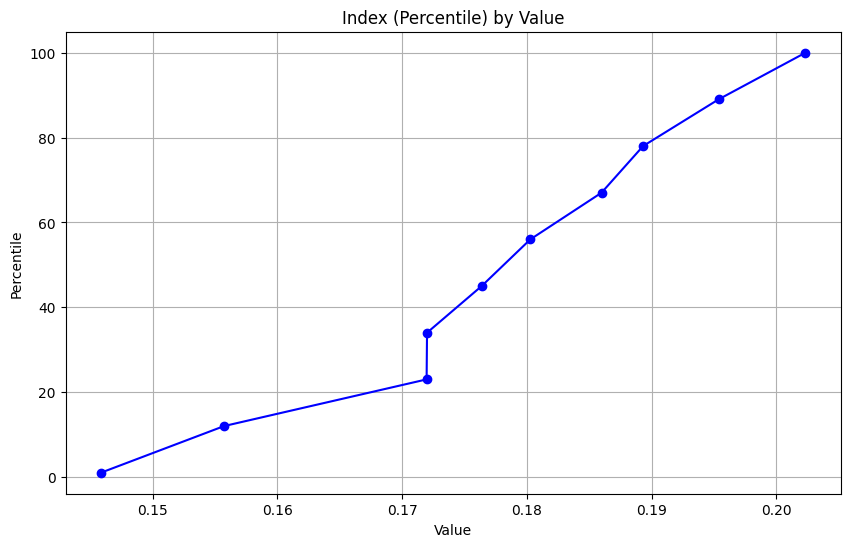

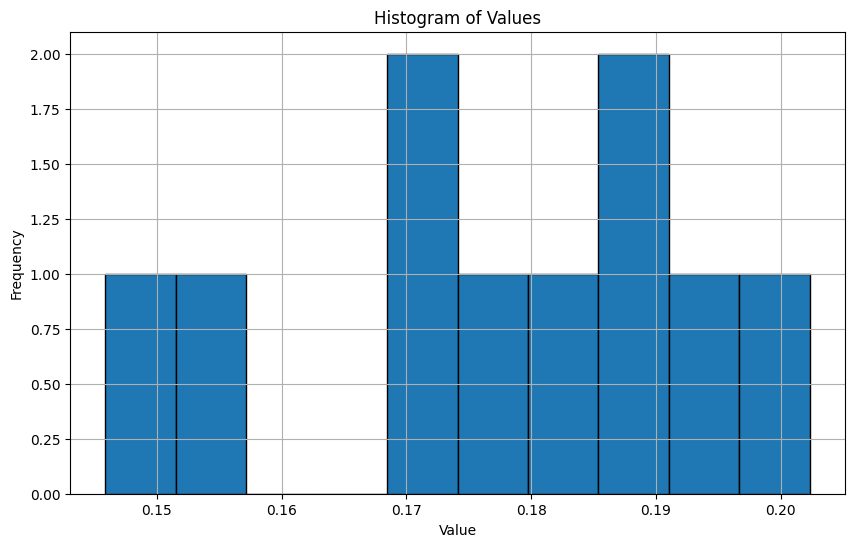

In [30]:
array = norm_dist_array[1]
# Generating y values as indices (percentiles in this context)
y_values = np.linspace(1, 100, len(array))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(array, y_values, marker='o', linestyle='-', color='b')
plt.title('Index (Percentile) by Value')
plt.xlabel('Value')
plt.ylabel('Percentile')
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(array, bins=len(array), edgecolor='black')
plt.title('Histogram of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



In [31]:
keep_cols = ['water', 'trees','grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built',
            'bare', 'snow_and_ice', 'max', 'elevation', 'landform', 'SRTM_mTPI','aet', 'def',
            'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn','tmmx', 'vap', 'vpd', 'vs',
            'agbd_m', 'agbd_sd', 'agbd_n']

scaled_numeric_df = prediction_list[0][keep_cols]
# numeric_cols = predictions.iloc[:,keep_cols]

scaled_numeric_df['norm_dist_array'] = norm_dist_array

# id_fields = predictions[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]

# numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)


<ipython-input-31-eadb985067ec>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df['norm_dist_array'] = norm_dist_array


In [32]:
numeric_df.columns

Index(['source_dataset', 'island', 'dist_id', 'soil_column_id', 'unique_id',
       'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude',
       'longitude', 'water', 'trees', 'grass', 'flooded_vegetation', 'crops',
       'shrub_and_scrub', 'built', 'bare', 'snow_and_ice', 'max', 'elevation',
       'landform', 'SRTM_mTPI', 'aet', 'def', 'pdsi', 'pet', 'pr', 'ro',
       'soil', 'srad', 'swe', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs', 'agbd_m',
       'agbd_sd', 'agbd_n', 'imp_c_scaled'],
      dtype='object')

In [38]:
# Model Definition
def build_model(input_shape,output_shape):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(512, activation='relu'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(output_shape, activation='linear')
    ])
    return model


In [34]:
scaled_numeric_df['norm_dist_array'] = scaled_numeric_df['norm_dist_array'].to_list()

<ipython-input-34-4a7713e6d101>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df['norm_dist_array'] = scaled_numeric_df['norm_dist_array'].to_list()


In [39]:
scaled_numeric_df.dropna(inplace=True)

<ipython-input-39-8f639aa31ceb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df.dropna(inplace=True)


In [40]:
norm_dist_array = np.array([i for i in scaled_numeric_df['norm_dist_array']])

In [41]:

X = scaled_numeric_df.iloc[:, :-1]
y = scaled_numeric_df.iloc[:, -1]

x = np.array(X)
y = np.array(norm_dist_array)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [42]:
# print(X_train.shape[1])
model = build_model(X_train.shape[1],output_shape=10)

In [43]:
y_train.shape

(2101, 10)

In [44]:
# model = build_model((X_train.shape[1]))
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error',metrics = ['mae'])
# model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error',metrics = ['mae'])
model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)
model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error',metrics = ['mae'])
model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)

test_loss = model.evaluate(X_test, y_test)

# Predictions and Evaluation
predictions = model.predict(X_test)

Epoch 1/600
14/14 [==============================] - 3s 21ms/step - loss: 1.9115 - mae: 1.0313 - val_loss: 0.0681 - val_mae: 0.1946
Epoch 2/600
14/14 [==============================] - 0s 7ms/step - loss: 1.6325 - mae: 0.9546 - val_loss: 0.0718 - val_mae: 0.2037
Epoch 3/600
14/14 [==============================] - 0s 8ms/step - loss: 1.5027 - mae: 0.9176 - val_loss: 0.0736 - val_mae: 0.2078
Epoch 4/600
14/14 [==============================] - 0s 8ms/step - loss: 1.4241 - mae: 0.8883 - val_loss: 0.0742 - val_mae: 0.2095
Epoch 5/600
14/14 [==============================] - 0s 7ms/step - loss: 1.3517 - mae: 0.8661 - val_loss: 0.0751 - val_mae: 0.2115
Epoch 6/600
14/14 [==============================] - 0s 7ms/step - loss: 1.2543 - mae: 0.8358 - val_loss: 0.0757 - val_mae: 0.2123
Epoch 7/600
14/14 [==============================] - 0s 7ms/step - loss: 1.2121 - mae: 0.8182 - val_loss: 0.0757 - val_mae: 0.2125
Epoch 8/600
14/14 [==============================] - 0s 8ms/step - loss: 1.1740 - 

In [45]:
i = 4
for i in range(5):
  print(predictions[i])
  print(y_test[i])

[0.25730824 0.28832477 0.30883104 0.32215744 0.34026834 0.36509785
 0.3880676  0.40853742 0.4397831  0.4864906 ]
[0.30065382 0.32833758 0.33945397 0.34531623 0.37576914 0.39320764
 0.44447398 0.46993476 0.48549008 0.51760674]
[0.21369882 0.23957403 0.26033437 0.2755299  0.28489012 0.29532886
 0.30661115 0.32039028 0.34331992 0.37808013]
[0.21975173 0.31299293 0.31422892 0.31733093 0.33223724 0.3557724
 0.37261817 0.39463425 0.42373034 0.42389244]
[0.12269038 0.14547038 0.16389014 0.17238396 0.18484585 0.19228292
 0.20000197 0.20510498 0.21417496 0.22487292]
[0.11596711 0.1483708  0.15607832 0.1997985  0.20297046 0.23043934
 0.2337556  0.23859157 0.24955592 0.31185868]
[0.26996493 0.29157874 0.30191958 0.3097151  0.3120265  0.31771192
 0.3235164  0.33573583 0.34962648 0.38608798]
[0.31877303 0.3365975  0.33821106 0.3497142  0.35487354 0.36442062
 0.3909803  0.39387307 0.3953096  0.46840367]
[-0.01829202 -0.01178387 -0.00101992  0.00623351  0.01281583  0.02440055
  0.03241429  0.03990334

In [46]:
xval_data = numeric_df[numeric_df['dist_id']==xval_id]

In [47]:
xval_predictions = model.predict(xval_data[keep_cols])

151/151 [==============================] - 0s 1ms/step


In [48]:
xval_data

,source_dataset,island,dist_id,soil_column_id,unique_id,depth_top,depth_bottom,depth_adj_bottom,latitude,longitude,...,swe,tmmn,tmmx,vap,vpd,vs,agbd_m,agbd_sd,agbd_n,imp_c_scaled
2402,HISOC,Maui,3.0,HISOC686,HISOC1974,0,20,20,20.83,-156.363,...,0.0,0.855827,0.886708,0.881096,0.713202,0.615275,0.000391,0.000298,0.413793,0.020407
2402,HISOC,Maui,3.0,HISOC686,HISOC1974,0,20,20,20.83,-156.363,...,0.0,0.855827,0.886708,0.881096,0.713202,0.615275,0.000641,0.000548,0.258621,0.020407
2402,HISOC,Maui,3.0,HISOC686,HISOC1974,0,20,20,20.83,-156.363,...,0.0,0.855827,0.886708,0.881096,0.713202,0.615275,0.000383,0.000312,0.310345,0.020407
2402,HISOC,Maui,3.0,HISOC686,HISOC1974,0,20,20,20.83,-156.363,...,0.0,0.855827,0.886708,0.881096,0.713202,0.615275,0.000597,0.001027,0.379310,0.020407
2402,HISOC,Maui,3.0,HISOC686,HISOC1974,0,20,20,20.83,-156.363,...,0.0,0.855827,0.886708,0.881096,0.713202,0.615275,0.000668,0.001249,0.258621,0.020407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3026,HISOC,Maui,3.0,HISOC788,HISOC2598,0,20,20,20.83,-156.363,...,0.0,0.886198,0.909862,0.906573,0.763814,0.630614,0.000539,0.000000,0.017241,0.018836
3026,HISOC,Maui,3.0,HISOC788,HISOC2598,0,20,20,20.83,-156.363,...,0.0,0.886198,0.909862,0.906573,0.763814,0.630614,0.001429,0.008248,0.258621,0.018836
3026,HISOC,Maui,3.0,HISOC788,HISOC2598,0,20,20,20.83,-156.363,...,0.0,0.886198,0.909862,0.906573,0.763814,0.630614,0.000581,0.000514,0.137931,0.018836
3026,HISOC,Maui,3.0,HISOC788,HISOC2598,0,20,20,20.83,-156.363,...,0.0,0.886198,0.909862,0.906573,0.763814,0.630614,0.000682,0.000598,0.086207,0.018836


In [49]:
xval_norm_predictions = [prediction*max_c+min_c for prediction in xval_predictions]

In [50]:
xval_quantiles = np.quantile((xval_data['imp_c_scaled']*max_c+min_c).unique(), np.linspace(0, 1,10))

In [51]:
[np.mean(np.sort(prediction) - np.sort(xval_quantiles)) for prediction in xval_norm_predictions]

[6.7617788668926035,
 5.886779057627467,
 6.2534942981059825,
 6.329251181727199,
 6.341036975031642,
 6.709065997248439,
 6.348244988566188,
 6.224286543970851,
 6.192770421152858,
 6.694423281794338,
 5.953562056666163,
 6.183572518473414,
 4.961140119677333,
 6.042898547297267,
 6.423531806116847,
 6.07389410698965,
 6.002554022913722,
 6.108604037409572,
 5.912016188746241,
 6.196766793375758,
 4.626427089815882,
 6.362387501841335,
 6.014035308008937,
 5.195900356417445,
 5.964250170832424,
 6.194867121821193,
 5.973137414103297,
 5.396023833399562,
 4.603976070528773,
 4.944269454127101,
 3.73940011227682,
 5.164072215204982,
 5.345029246454982,
 5.379333626871852,
 5.189852797632961,
 4.2259265538509165,
 4.197501098757533,
 4.244288503771571,
 4.295784580355433,
 4.393745314722804,
 3.543873417025355,
 3.9973191853816785,
 4.461975896006374,
 4.065969597941188,
 4.030829131251124,
 4.248376786356715,
 4.163953005915431,
 4.074322545176296,
 4.082949840670375,
 6.761778866892603

In [52]:
xval_data['mean_resid']= [np.mean(np.sort(prediction) - np.sort(xval_quantiles)) for prediction in xval_norm_predictions]

<ipython-input-52-c3ba60135f41>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xval_data['mean_resid']= [np.mean(np.sort(prediction) - np.sort(xval_quantiles)) for prediction in xval_norm_predictions]


In [53]:
xval_data['geometry'] = [Point(xy) for xy in zip(xval_data['longitude'], xval_data['latitude'])]

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(xval_data, geometry='geometry')

# Set the coordinate reference system (CRS) for the GeoDataFrame
gdf.set_crs(epsg=4326, inplace=True)

gdf.to_file('test.gpkg')

<ipython-input-53-da703ab16e03>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xval_data['geometry'] = [Point(xy) for xy in zip(xval_data['longitude'], xval_data['latitude'])]


In [54]:
def normal_generator(n, mean, sd, mean_variation, sd_variation):
    variable_mean = mean + np.random.normal(0, mean_variation * 2)
    variable_sd = sd + abs(np.random.normal(0, sd_variation * 2))
    return np.random.normal(variable_mean, variable_sd, n)

def uniform_generator(n, min_val, max_val, min_variation, max_variation):
    variable_min = min_val + np.random.uniform(-min_variation * 2, min_variation * 2)
    variable_max = max_val + np.random.uniform(-max_variation * 2, max_variation * 2)
    return np.random.uniform(variable_min, variable_max, n)

def right_tailed_generator(n, mean, sd, mean_variation, sd_variation):
    variable_mean = mean + np.random.normal(0, mean_variation * 2)
    variable_sd = sd + abs(np.random.normal(0, sd_variation * 2))
    return np.random.lognormal(variable_mean, variable_sd, n)

def left_tailed_generator(n, mean, sd, mean_variation, sd_variation):
    variable_mean = mean + np.random.normal(0, mean_variation * 2)
    variable_sd = sd + abs(np.random.normal(0, sd_variation * 2))
    return -np.random.lognormal(variable_mean, variable_sd, n)

def multimodal_generator(ns, means, sds, mean_variation, sd_variation):
    samples_list = []
    for i in range(len(means)):
        variable_mean = means[i] + np.random.normal(0, mean_variation * 2)
        variable_sd = sds[i] + abs(np.random.normal(0, sd_variation * 2))
        samples_list.append(np.random.normal(variable_mean, variable_sd, ns[i]))
    return np.concatenate(samples_list)

In [55]:
def rescale_to_minus_one_one(values):
    min_value = np.min(values)
    max_value = np.max(values)
    scaled_values = 2 * ((values - min_value) / (max_value - min_value)) - 1
    return scaled_values

In [56]:
def generate_samples(n, q, generator_func, *args):
    samples = generator_func(n, *args)
    samples_q = np.quantile(samples, np.linspace(0, 1, q))
    return rescale_to_minus_one_one(samples_q)

def generate_normal_samples(n=10000, q=10, mean_value=0, sd_value=1, mean_variation=0.5, sd_variation=0.5):
    return generate_samples(n, q, normal_generator, mean_value, sd_value, mean_variation, sd_variation)

def generate_uniform_samples(n=10000, q=10, min_value=-1, max_value=1, min_variation=0.5, max_variation=0.5):
    return generate_samples(n, q, uniform_generator, min_value, max_value, min_variation, max_variation)

def generate_right_tailed_samples(n=10000, q=10, mean=0, sd=1, mean_variation=0.5, sd_variation=0.5):
    return generate_samples(n, q, right_tailed_generator, mean, sd, mean_variation, sd_variation)

def generate_left_tailed_samples(n=10000, q=10, mean=0, sd=1, mean_variation=0.5, sd_variation=0.5):
    return generate_samples(n, q, left_tailed_generator, mean, sd, mean_variation, sd_variation)

def generate_multimodal_samples(ns=[1000, 50], q=10, means=[1, -1], sds=[1, 0.5], mean_variation=0.5, sd_variation=0.5):
    samples = multimodal_generator(ns, means, sds, mean_variation, sd_variation)
    samples_q = np.quantile(samples, np.linspace(0, 1, q))
    return rescale_to_minus_one_one(samples_q)


In [57]:
def generate_training_data(n_samples=10000):
    data_list = {}

    # Generate samples for each distribution type
    data_list['normal'] = [generate_normal_samples() for _ in range(n_samples)]
    data_list['bimodal'] = [generate_multimodal_samples() for _ in range(n_samples)]
    data_list['uniform'] = [generate_uniform_samples() for _ in range(n_samples)]
    data_list['right_tailed'] = [generate_right_tailed_samples() for _ in range(n_samples)]
    data_list['left_tailed'] = [generate_left_tailed_samples() for _ in range(n_samples)]

    # Combine all data into a single DataFrame
    combined_data = pd.DataFrame()
    for name, samples_list in data_list.items():
        df = pd.DataFrame(samples_list)
        df['label'] = name
        combined_data = pd.concat([combined_data, df], ignore_index=True)

    # Assign column names
    combined_data.columns = [f'V{i+1}' for i in range(combined_data.shape[1] - 1)] + ['label']

    return combined_data

In [58]:
training_data = generate_training_data()

In [60]:
# Separate features and labels
X = training_data.drop(columns=['label'])
y = training_data['label']

# Encode labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, min_samples_leaf=2, random_state=123)

# Train the model
rf_model.fit(X, y_encoded)

# Print the trained model
print(rf_model)

RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500,
                       random_state=123)


In [61]:
reference_rf_ready_predictions = [rescale_to_minus_one_one(sorted(prediction)) for prediction in  y_test]

In [62]:
some_new_data = training_data = generate_training_data()

In [63]:
prediction_rf_ready_predictions = [rescale_to_minus_one_one(sorted(prediction)) for prediction in  predictions]

In [64]:
xval_data

,source_dataset,island,dist_id,soil_column_id,unique_id,depth_top,depth_bottom,depth_adj_bottom,latitude,longitude,...,tmmx,vap,vpd,vs,agbd_m,agbd_sd,agbd_n,imp_c_scaled,mean_resid,geometry
2402,HISOC,Maui,3.0,HISOC686,HISOC1974,0,20,20,20.83,-156.363,...,0.886708,0.881096,0.713202,0.615275,0.000391,0.000298,0.413793,0.020407,6.761779,POINT (-156.363 20.83)
2402,HISOC,Maui,3.0,HISOC686,HISOC1974,0,20,20,20.83,-156.363,...,0.886708,0.881096,0.713202,0.615275,0.000641,0.000548,0.258621,0.020407,5.886779,POINT (-156.363 20.83)
2402,HISOC,Maui,3.0,HISOC686,HISOC1974,0,20,20,20.83,-156.363,...,0.886708,0.881096,0.713202,0.615275,0.000383,0.000312,0.310345,0.020407,6.253494,POINT (-156.363 20.83)
2402,HISOC,Maui,3.0,HISOC686,HISOC1974,0,20,20,20.83,-156.363,...,0.886708,0.881096,0.713202,0.615275,0.000597,0.001027,0.379310,0.020407,6.329251,POINT (-156.363 20.83)
2402,HISOC,Maui,3.0,HISOC686,HISOC1974,0,20,20,20.83,-156.363,...,0.886708,0.881096,0.713202,0.615275,0.000668,0.001249,0.258621,0.020407,6.341037,POINT (-156.363 20.83)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3026,HISOC,Maui,3.0,HISOC788,HISOC2598,0,20,20,20.83,-156.363,...,0.909862,0.906573,0.763814,0.630614,0.000539,0.000000,0.017241,0.018836,4.030829,POINT (-156.363 20.83)
3026,HISOC,Maui,3.0,HISOC788,HISOC2598,0,20,20,20.83,-156.363,...,0.909862,0.906573,0.763814,0.630614,0.001429,0.008248,0.258621,0.018836,4.248377,POINT (-156.363 20.83)
3026,HISOC,Maui,3.0,HISOC788,HISOC2598,0,20,20,20.83,-156.363,...,0.909862,0.906573,0.763814,0.630614,0.000581,0.000514,0.137931,0.018836,4.163953,POINT (-156.363 20.83)
3026,HISOC,Maui,3.0,HISOC788,HISOC2598,0,20,20,20.83,-156.363,...,0.909862,0.906573,0.763814,0.630614,0.000682,0.000598,0.086207,0.018836,4.074323,POINT (-156.363 20.83)


In [349]:
real_quantiles.columns = [f'V{i+1}' for i in range(real_quantiles.shape[1])]

NameError: name 'real_quantiles' is not defined

In [352]:
real_data_rf_ready_predictions = [rescale_to_minus_one_one(sorted(prediction)) for prediction in  np.array(real_quantiles) ]

NameError: name 'real_quantiles' is not defined

In [353]:
# Assuming real_data_rf_ready_predictions is your list of predictions
real_data_rf_ready_predictions = [prediction for prediction in real_data_rf_ready_predictions if not np.any(np.isnan(prediction))]


NameError: name 'real_data_rf_ready_predictions' is not defined

In [354]:
real_data_rf_ready_predictions

NameError: name 'real_data_rf_ready_predictions' is not defined

In [355]:
real_quantiles = quantiles.unstack().reset_index().iloc[:,1:]

ValueError: index must be a MultiIndex to unstack, <class 'pandas.core.indexes.base.Index'> was passed

In [ ]:
real_data_rf_ready_predictions

In [ ]:
# Assuming `new_data` is your new dataset without the 'label' column

# Use the trained model to make predictions
predicted_labels_encoded = rf_model.predict(real_data_rf_ready_predictions)

# Decode the encoded labels back to original labels
predicted_predicted_labels = label_encoder.inverse_transform(predicted_labels_encoded)

# Output the predictions
print(predicted_predicted_labels)


In [ ]:
cm = confusion_matrix(predicted_predicted_labels, reference_predicted_labels)
cm

In [ ]:

# Assuming 'my_array' is your numpy array
unique_values, counts = np.unique(predicted_predicted_labels, return_counts=True)

# Create a DataFrame to display the counts in a table format
counts_table = pd.DataFrame({
    'Unique Value': unique_values,
    'Count': counts
})

# Display the table
print(counts_table)


In [ ]:
unique_values, counts = np.unique(predicted_labels, return_counts=True)

# Create a DataFrame to display the counts in a table format
counts_table = pd.DataFrame({
    'Unique Value': unique_values,
    'Count': counts
})

# Display the table
print(counts_table)


In [ ]:
# matches_within_distance[matches_within_distance['dist_id']!=xval_id].groupby('unique_id').sample(n=1)

In [ ]:
xval_data = matches_within_distance[matches_within_distance['dist_id']==xval_id]

In [ ]:
quantiles = xval_data[xval_data['depth_adj_bottom'] =="20" ].groupby('unique_id').sample(n=1)['imp_c'].astype(float).quantile(np.linspace(0, 1,10))

In [ ]:
keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,36,36,37,38,39,40,41,42,43,44,45,46,47, 48]

numeric_cols = xval_data.iloc[:,keep_cols]

# scaler = MinMaxScaler()

scaler.fit(numeric_cols)

scaled_numeric_cols = scaler.transform(numeric_cols)

scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)

# scaled_numeric_df['norm_dist_array'] = norm_dist_array

id_fields = xval_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]

numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)

In [ ]:
X = scaled_numeric_df.iloc[:, :-1]


In [ ]:
predictions = model.predict(scaled_numeric_df)

In [ ]:
predictions

In [ ]:
dummy_array = np.full((len(predictions), 28), fill_value=0.5)  # Example for reverse scaling
dummy_array[:, -1] = predictions
inversed_predictions = scaler.inverse_transform(dummy_array)[:, -1]
dummy_array[:, -1] = y_test
inversed_truth = scaler.inverse_transform(dummy_array)[:, -1]